# NNDL miniproj3 AC GAN
* sajjad pakdaman [810195517]
* fatemeh haghighi [810195385]

## setup
import necessary libs

In [ ]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, BatchNormalization, Dropout, Embedding
from keras.layers import Activation, Concatenate 
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.utils import to_categorical, Progbar
from keras.datasets import cifar10
import numpy as np

Using TensorFlow backend.


## discriminator

In [ ]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # layer 1
    fe = Conv2D(16, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # layer 2
    fe = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # layer 3
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # layer 4
    fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # layer 5
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # layer 6
    fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

## generator

In [ ]:
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(n_classes,))
    in_lat = Input(shape=(latent_dim,))
    # layer 1
    merge = Concatenate()([in_lat, in_label])
    n_nodes = 384 
    gen = Dense(n_nodes, kernel_initializer=init)(merge)
    gen = Activation('relu')(gen)
    gen = Reshape((1, 1, 384))(gen)
    # layer 2
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # layer 3
    gen = Conv2DTranspose(96, (5,5), strides=(4,4), padding='same', kernel_initializer=init)(gen)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # layer 4
    gen = Conv2DTranspose(3, (5,5), strides=(4,4), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

## Adversial
define the combined generator and discriminator model, for updating the generator

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
	return model

## utils

In [ ]:
def load_real_samples():
    # load dataset
    (trainX, trainy), (testX, testy) = cifar10.load_data()

    X = np.concatenate((trainX, testX))
    Y = np.concatenate((trainy, testy))
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    Y = to_categorical(Y)
    print(X.shape, Y.shape)
    return [X, Y]

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10, uniform=False):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    if not uniform:
        labels = randint(0, n_classes, n_samples)
    else:
        labels = np.array([[j for j in range(int(n_samples/n_classes))] for i in range(n_classes)]).reshape(-1, 1)
    labels = to_categorical(labels, num_classes=n_classes)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples, uniform=False):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples, uniform=uniform)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# generate samples and save as a plot and save the model
class_names = ['airplane','car','bird','cat','deer',
               'dog','frog','horse','ship','truck']
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    fig = pyplot.figure(figsize=(10,10))
    fig.suptitle(f'epoch {step}')
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples, uniform=True)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, :])
        if i < 10:
            pyplot.title(class_names[i])
    # save plot to file
    pyplot.show()
    filename1 = 'image_generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    # filename2 = 'model_%04d.h5' % (step+1)
    # g_model.save(filename2)
    # print('>Saved: %s and %s' % (filename1, filename2))

## train loop

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2, n_batch=100, history=None):
    # check if history is none
    if history is None:
        history = {'dr1':[], 'dr2':[], 'df1':[], 'df2':[], 'g1':[], 'g2':[]}
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for e in range(n_epochs):
        # init progress bar
        print(f'epoch: {e+1}')
        progbar = Progbar(target=n_steps)
        for i in range(n_steps):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
            # generate 'fake' examples
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            # prepare points in latent space as input for the generator
            [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
            # summarize loss on this batch
            progbar.update(i, [('dr1', d_r1), ('dr2', d_r2), ('df1', d_f), ('df2', d_f2), ('g1', g_1), ('g2', g_2)])
            history['dr1'].append(d_r1)
            history['dr2'].append(d_r2)
            history['df1'].append(d_f)
            history['df2'].append(d_f2)
            history['g1' ].append(g_1)
            history['g2' ].append(g_2)
            # print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
            # evaluate the model performance every 'epoch'
        summarize_performance(e+1, g_model, latent_dim)
    return history

## make models

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 16, 16, 16)   0           leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [ ]:
# create the generator
generator = define_generator(latent_dim)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 384)          42624       concatenate_1[0][0]        

In [ ]:
# make ac_gan model
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 384)          42624       concatenate_1[0][0]        

In [ ]:
# make history
history = {'dr1':[], 'dr2':[], 'df1':[], 'df2':[], 'g1':[], 'g2':[]}
# load image data
dataset = load_real_samples()
epochs = 120

170500096/170498071 [==============================] - 2s 0us/step
(60000, 32, 32, 3) (60000, 10)


In [ ]:
# train model
history = train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=epochs, history=history)

## plot loss

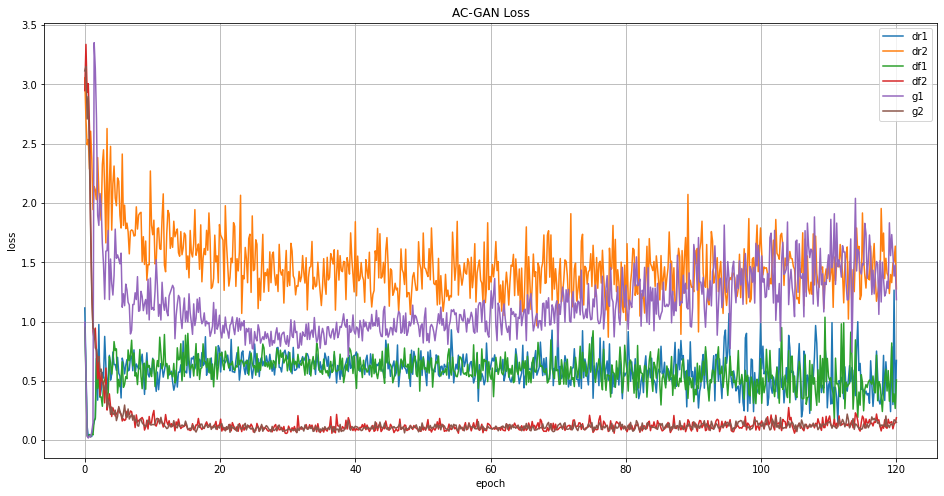

In [ ]:
pyplot.figure(figsize=(16,8))
step = 60
for key in history:
    x = np.linspace(0, epochs, int((len(history[key])+59)/step))
    pyplot.plot(x, history[key][::step], label=key)
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.title('AC-GAN Loss')
pyplot.legend()
pyplot.grid()

## make gif

In [ ]:
import PIL
import imageio
import glob

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'acgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>